In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from joblib import dump

In [2]:
claims_df = pd.read_csv('../data/processed/dim_claims_train.csv').fillna(0)
claims_df.loc[:, 'reject_code'] = claims_df['reject_code'].astype(int)

pa_df = pd.read_csv('../data/processed/dim_pa_train.csv')
bridge_df = pd.read_csv('../data/processed/bridge_train.csv')

combined_df = bridge_df.merge(claims_df, on='dim_claim_id').merge(pa_df, on='dim_pa_id')

claims_X = combined_df[['bin', 'drug', 'correct_diagnosis', 'tried_and_failed', 'contraindication']]
claims_y = combined_df['pa_approved']

# Tasks
- Final Optimization of Hyperparameters
    - False positives have been determined to be worse than false negatives.
    - Reducing false positives can be performed by prioritizing recall.
- Test Split Model Evaluation

In [3]:
def build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes):
    encoder = OneHotEncoder(sparse=False, drop='first')
    model = DecisionTreeClassifier(random_state=42, 
                                   ccp_alpha=ccp_alpha, 
                                   min_impurity_decrease=min_impurity_decrease,
                                   max_leaf_nodes=max_leaf_nodes)
    pipe = Pipeline([('encoder', encoder),
                     ('model', model)])
    return pipe   

## Model without Constraints

In [4]:
ccp_alpha = 0
min_impurity_decrease = 0
max_leaf_nodes = 96

pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
pipe.fit(claims_X, claims_y)
ccp_alphas = pipe['model'].cost_complexity_pruning_path(pipe['encoder'].transform(claims_X), claims_y)['ccp_alphas']

## Model with `max_leaf_node` Scan

In [5]:
fit_results = []

ccp_alpha = 0
min_impurity_decrease = 0

for max_leaf_nodes in range(30, 96):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []
    roc_auc = []
    n_leaves = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X.iloc[train_index], claims_X.iloc[test_index]
        y_train, y_test = claims_y.iloc[train_index], claims_y.iloc[test_index]

        pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
        pipe.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, pipe.predict(X_test)))
        precision.append(precision_score(y_test, pipe.predict(X_test)))
        recall.append(recall_score(y_test, pipe.predict(X_test)))
        roc_auc.append(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))
        n_leaves.append(pipe['model'].get_n_leaves())

    accuracy = np.mean(accuracy)
    recall = np.mean(recall)
    precision = np.mean(precision)
    roc_auc = np.mean(roc_auc)
    n_leaves = np.mean(n_leaves)

    fit_results.append({'ccp_alpha': ccp_alpha,
                        'min_impurity_decrease': min_impurity_decrease,
                        'max_leaves': max_leaf_nodes,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'roc_auc': roc_auc,
                        'n_leaves': n_leaves})

## Model with `min_impurity_decrease` and `ccp_alpha` Scan

In [6]:
max_leaf_nodes = 96

for min_impurity_decrease in np.linspace(0, 0.0002, 11):
    for ccp_alpha in ccp_alphas:
        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        cv.get_n_splits(claims_X)

        accuracy = []
        precision = []
        recall = []
        roc_auc = []
        n_leaves = []

        for train_index, test_index in cv.split(claims_X):
            X_train, X_test = claims_X.iloc[train_index], claims_X.iloc[test_index]
            y_train, y_test = claims_y.iloc[train_index], claims_y.iloc[test_index]

            pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
            pipe.fit(X_train, y_train)

            accuracy.append(accuracy_score(y_test, pipe.predict(X_test)))
            precision.append(precision_score(y_test, pipe.predict(X_test)))
            recall.append(recall_score(y_test, pipe.predict(X_test)))
            roc_auc.append(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))
            n_leaves.append(pipe['model'].get_n_leaves())

        accuracy = np.mean(accuracy)
        recall = np.mean(recall)
        precision = np.mean(precision)
        roc_auc = np.mean(roc_auc)
        n_leaves = np.mean(n_leaves)

        fit_results.append({'ccp_alpha': ccp_alpha,
                            'min_impurity_decrease': min_impurity_decrease,
                            'max_leaves': max_leaf_nodes,
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall,
                            'roc_auc': roc_auc,
                            'n_leaves': n_leaves})

    ccp_alphas = pipe['model'].cost_complexity_pruning_path(pipe['encoder'].transform(claims_X), claims_y)['ccp_alphas']
fit_results = pd.DataFrame(fit_results)

## Scores vs. Number of Leaves

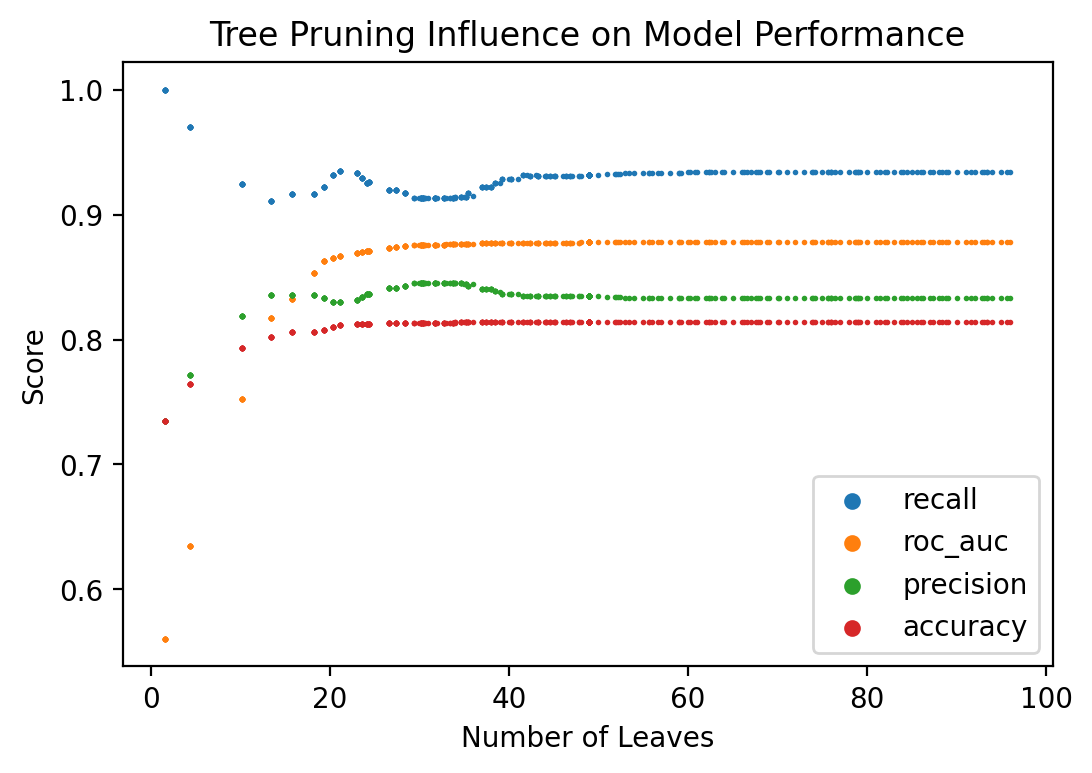

In [7]:
plt.figure(dpi=200)

x = fit_results['n_leaves']

for name, y in fit_results[['recall', 'roc_auc', 'precision', 'accuracy']].iteritems():
    plt.scatter(x, y, s=1, label=name)

plt.title('Tree Pruning Influence on Model Performance')
plt.ylabel('Score')
plt.xlabel('Number of Leaves')
plt.legend(markerscale=5)
plt.show()

## Trying to get Variance

In [8]:
ccp_alpha = 0
min_impurity_decrease = 0
max_leaf_nodes = 96

pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
pipe.fit(claims_X, claims_y)
ccp_alphas = pipe['model'].cost_complexity_pruning_path(pipe['encoder'].transform(claims_X), claims_y)['ccp_alphas']

## Model with `max_leaf_node` Scan

In [9]:
fit_results = []

ccp_alpha = 0
min_impurity_decrease = 0

for max_leaf_nodes in range(30, 96):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X.iloc[train_index], claims_X.iloc[test_index]
        y_train, y_test = claims_y.iloc[train_index], claims_y.iloc[test_index]

        pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
        pipe.fit(X_train, y_train)

        accuracy = accuracy_score(y_test, pipe.predict(X_test))
        precision = precision_score(y_test, pipe.predict(X_test))
        recall = recall_score(y_test, pipe.predict(X_test))
        roc_auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
        n_leaves = pipe['model'].get_n_leaves()

        fit_results.append({'ccp_alpha': ccp_alpha,
                            'min_impurity_decrease': min_impurity_decrease,
                            'max_leaves': max_leaf_nodes,
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall,
                            'roc_auc': roc_auc,
                            'n_leaves': n_leaves})

## Model with `min_impurity_decrease` and `ccp_alpha` Scan

In [10]:
max_leaf_nodes = 96

for min_impurity_decrease in np.linspace(0, 0.0002, 11):
    for ccp_alpha in ccp_alphas:
        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        cv.get_n_splits(claims_X)

        accuracy = []
        precision = []
        recall = []
        roc_auc = []
        n_leaves = []

        for train_index, test_index in cv.split(claims_X):
            X_train, X_test = claims_X.iloc[train_index], claims_X.iloc[test_index]
            y_train, y_test = claims_y.iloc[train_index], claims_y.iloc[test_index]

            pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
            pipe.fit(X_train, y_train)


            accuracy = accuracy_score(y_test, pipe.predict(X_test))
            precision = precision_score(y_test, pipe.predict(X_test))
            recall = recall_score(y_test, pipe.predict(X_test))
            roc_auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
            n_leaves = pipe['model'].get_n_leaves()

            fit_results.append({'ccp_alpha': ccp_alpha,
                                'min_impurity_decrease': min_impurity_decrease,
                                'max_leaves': max_leaf_nodes,
                                'accuracy': accuracy,
                                'precision': precision,
                                'recall': recall,
                                'roc_auc': roc_auc,
                                'n_leaves': n_leaves})

    ccp_alphas = pipe['model'].cost_complexity_pruning_path(pipe['encoder'].transform(claims_X), claims_y)['ccp_alphas']
fit_results = pd.DataFrame(fit_results)

## Scores vs. Number of Leaves

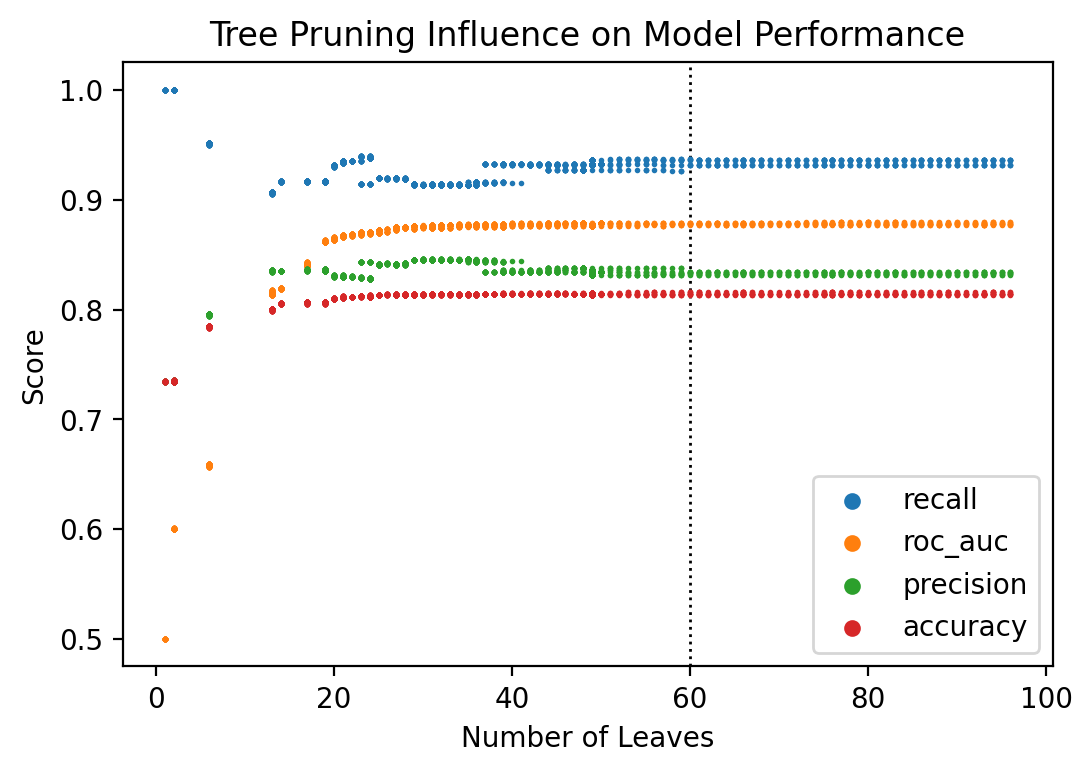

In [11]:
plt.figure(dpi=200)

x = fit_results['n_leaves']

for name, y in fit_results[['recall', 'roc_auc', 'precision', 'accuracy']].iteritems():
    plt.scatter(x, y, s=1, label=name)

plt.title('Tree Pruning Influence on Model Performance')
plt.ylabel('Score')
plt.xlabel('Number of Leaves')
plt.legend(markerscale=5)
plt.axvline(60, lw=1, color='k', ls=':', zorder=-1)
plt.show()

In [12]:
fit_results.loc[fit_results['n_leaves'] == 60].sort_values('max_leaves')

,ccp_alpha,min_impurity_decrease,max_leaves,accuracy,precision,recall,roc_auc,n_leaves
150,0.000000,0.0,60,0.814082,0.834275,0.931761,0.878776,60
151,0.000000,0.0,60,0.813891,0.831965,0.936312,0.876568,60
152,0.000000,0.0,60,0.814035,0.834458,0.931652,0.879148,60
153,0.000000,0.0,60,0.815542,0.833098,0.936832,0.878200,60
154,0.000000,0.0,60,0.813529,0.831168,0.936298,0.877494,60
513,0.000006,0.0,96,0.815542,0.833098,0.936832,0.878200,60
517,0.000007,0.0,96,0.814035,0.834458,0.931652,0.879148,60
518,0.000007,0.0,96,0.815542,0.833098,0.936832,0.878200,60
525,0.000008,0.0,96,0.814082,0.834275,0.931761,0.878776,60


In [13]:
final_pipe = build_pipe(0, 0, 60)
final_pipe.fit(claims_X, claims_y)
dump(final_pipe, './saved-models/decision-tree-pa-approval.joblib')

['./saved-models/decision-tree-pa-approval.joblib']

In [14]:
claims_test_df = pd.read_csv('../data/processed/dim_claims_test.csv').fillna(0)
claims_test_df.loc[:, 'reject_code'] = claims_test_df['reject_code'].astype(int)

pa_test_df = pd.read_csv('../data/processed/dim_pa_test.csv')
bridge_test_df = pd.read_csv('../data/processed/bridge_test.csv')

combined_test_df = bridge_test_df.merge(claims_test_df, on='dim_claim_id').merge(pa_test_df, on='dim_pa_id')

claims_X_test = combined_test_df[['bin', 'drug', 'correct_diagnosis', 'tried_and_failed', 'contraindication']]
claims_y_test = combined_test_df['pa_approved']

In [15]:
test_accuracy = accuracy_score(claims_y_test, final_pipe.predict(claims_X_test))
test_precision = precision_score(claims_y_test, final_pipe.predict(claims_X_test))
test_recall = recall_score(claims_y_test, final_pipe.predict(claims_X_test))
test_roc_auc = roc_auc_score(claims_y_test, final_pipe.predict_proba(claims_X_test)[:, 1])
test_n_leaves = final_pipe['model'].get_n_leaves()

print(f'Test Accuracy = {round(test_accuracy, 2)}')
print(f'Test Precision = {round(test_precision, 2)}')
print(f'Test Recall = {round(test_recall, 2)}')
print(f'Test ROC AUC = {round(test_roc_auc, 2)}')
print(f'Test # Leaves = {test_n_leaves}')

Test Accuracy = 0.81
Test Precision = 0.83
Test Recall = 0.94
Test ROC AUC = 0.88
Test # Leaves = 60
